**Author:** *Johannes Peter Knoll*

# Introduction

This notebook shows how to access and visualize (at least up to a certain point) the results of the 
extensive computations made in the `main.py` file.

As the number of operations performed on the GIF data was higher than on the NAKO data, we will use the
GIF's results as demonstration.

In [12]:
# The autoreload extension allows you to tweak the code in the imported modules
# and rerun cells to reflect the changes.
%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# IMPORTS
import random
import numpy as np

In [14]:
# LOCAL IMPORTS
import main
import read_edf
import MAD
import rpeak_detection
import check_data
import plot_helper
import rri_from_rpeak
from side_functions import *

parameters = main.parameters

# How results are saved:

The results of the computation are saved as dictionaries (one for each .edf file) to a pickle file. If you
did not change the default key definitions in the `project_parameters.py` file, you can access the results as
follows:

- "MAD": MAD values calculated from wrist accelerometry data
- "MAD_frequency": Sampling frequency of calculated MAD values (equals 1 / `mad_time_period_seconds`, see `main.py` 'PROJECT PARAMETERS' section)
- "RRI": RR intervals calculated from detected r-peaks
- "RRI_frequency": Sampling frequency of calculated RRI values, set by `RRI_sampling_frequency` (see `main.py` 'PROJECT PARAMETERS' section)

These were the important ones. The following are **less important**, but they are mentioned for completeness:

- "file_name": Name of .edf file
- "valid_ecg_regions_(`strictness_value_1`)": Valid ECG regions estimated using strictness = `strictness_value_1`,
- "valid_ecg_regions_(`strictness_value_2`)": Valid ECG regions estimated using strictness = `strictness_value_2`,\
- ...
- "valid_ecg_regions": Valid ECG regions used for r-peak detection
- "valid_intervals_from_ecg_classification": Valid ECG regions provided by GIF
- "ecg_validation_comparison": Comparison between GIF's and calculated ECG Validation
- "`rpeak_function_name_1`": r-peaks detected by function referred to with `rpeak_function_name_1`,
- "`rpeak_function_name_2`": r-peaks detected by function referred to with `rpeak_function_name_2`,
- ...
- "rpeak_comparison": Comparison_values between all r_peak detection methods

**Note:**   The Comparison between the ecg validation and r-peak detection of gif and this project can be found 
as .txt file in the same directory where the other results (.pkl file) are stored.

# Access Important Results

Remember: The results for every .edf file (within one directory) are saved to one .pkl file as individual 
dictionaries.

Using the functions implemented in this project, we can load these results as a generator:

In [16]:
gif_results_path = "Processed_GIF/GIF_Results.pkl"
important_dictionary_keys = ["file_name", "RRI", "RRI_frequency", "MAD", "MAD_frequency"]

results_generator = load_from_pickle(gif_results_path)

# Load the first entry
first_entry = next(results_generator)
for key in important_dictionary_keys:
    if key in ["RRI", "MAD"]:
        print(f"{key}: {len(first_entry[key])}")
    else:
        print(f"{key}: {first_entry[key]}")

file_name: SL001_SL001_(1).edf
RRI: 186920
RRI_frequency: 4
MAD: 46730
MAD_frequency: 1.0


Above we have shown how to access the first entry in the .pkl file. 

If you don't know how generators work, look it up. For now in short: To access all results, one after another,
just iterate over the generator:

In [17]:
count = 0
for generator_entry in results_generator:
    count += 1
    pass

print(f"The generator still had {count} entries left.")

The generator still had 9 entries left.


Now we know how to access the most important results. If you want, you can skip the rest of this notebook, as
we are looking at the less important interim results, like ECG Validation and R-Peak detection.

In the following, we will not access the results directly via the keys documented above. They are easily 
changeable in the `project_parameters.py` file and are stored in the parameters dictionary. (Seems quite 
unnecessary, I know, but I wanted to give the user the option to change the keys, if he/she did not like
my definitions)

# Visualize ECG Validation

(Valid / Total) Regions Ratio: 78.120000 %


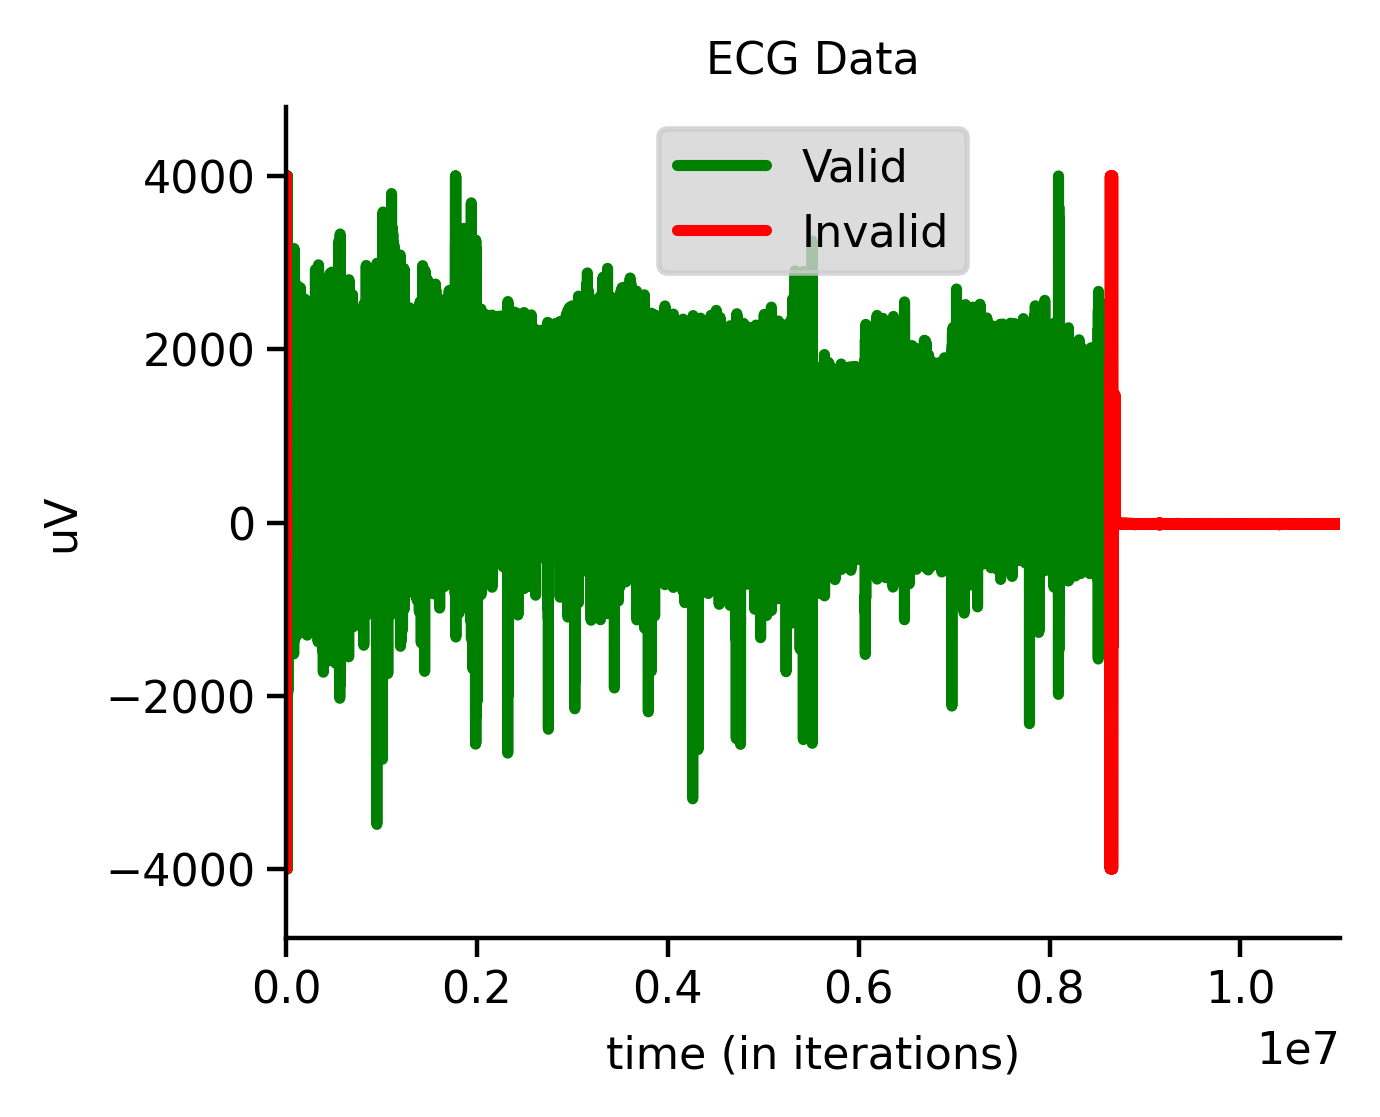

In [18]:
# choose a random file
file_data_name = "SL104_SL104_(1).edf"
file_data_path = "Data/GIF/SOMNOwatch/" + file_data_name

gif_results_path = "Processed_GIF/GIF_Results.pkl"

# load the valid regions
results_generator = load_from_pickle(gif_results_path)
for generator_entry in results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_valid_ecg_regions = generator_entry[parameters["valid_ecg_regions_dictionary_key"]]
        break

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# calculate the ratio of valid regions to total regions
valid_regions_ratio = check_data.determine_valid_total_ecg_ratio(
    ECG_length = len(ECG), 
    valid_regions = this_files_valid_ecg_regions
    )
print("(Valid / Total) Regions Ratio: %f %%" % (round(valid_regions_ratio, 4)*100))

total_length = len(ECG)
x_lim = [int(0*total_length), int(1*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions,
    xlim = x_lim
    )

# Compare GIFs and this projects ECG Validation

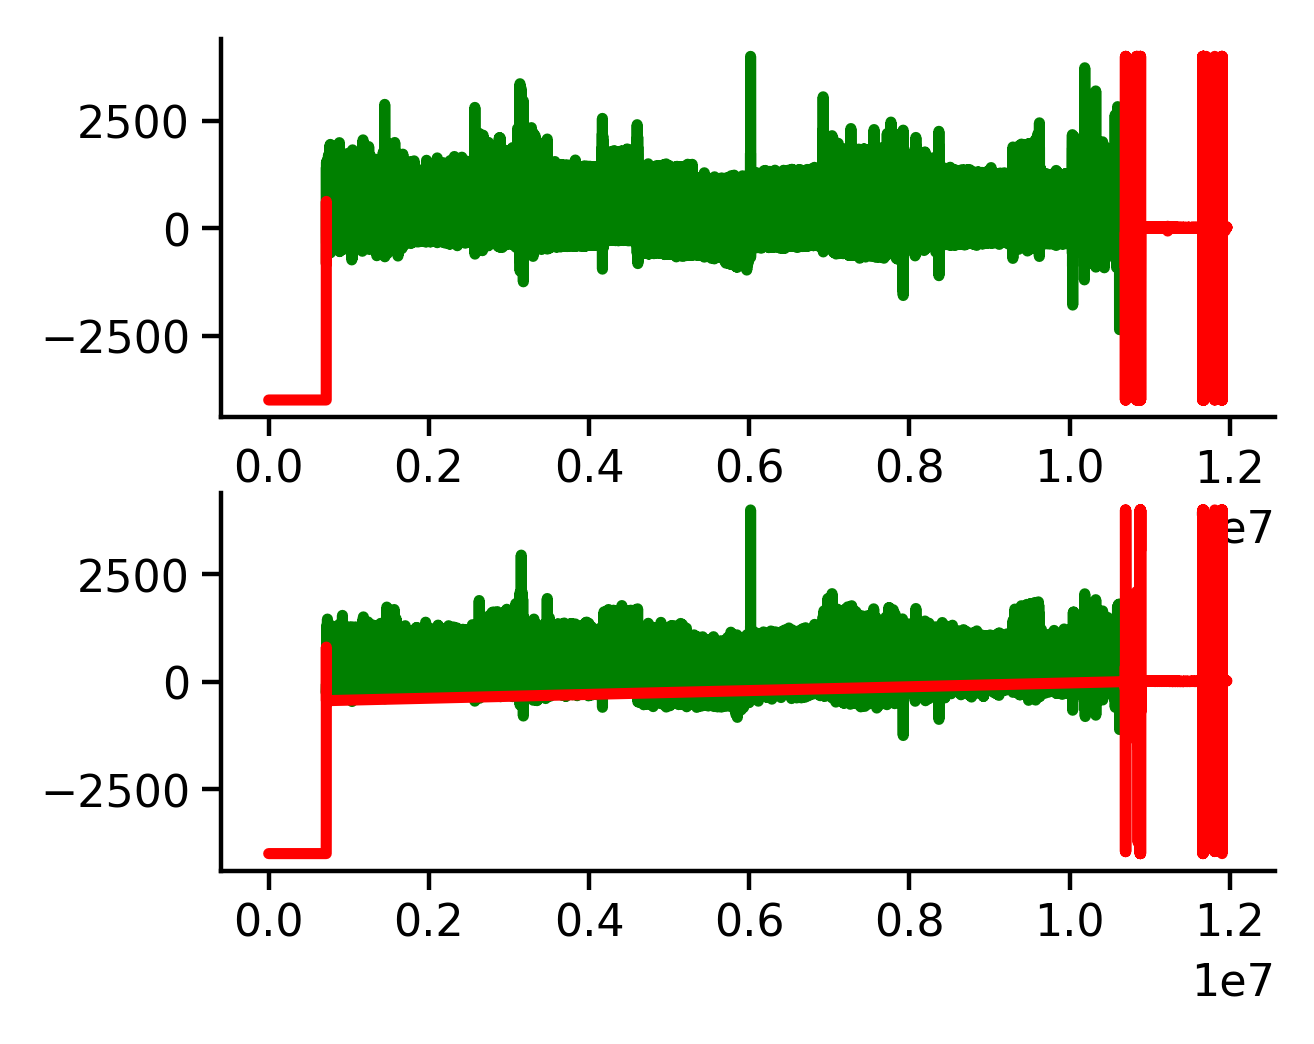

In [20]:
# choose random file
file_data_name = "SL001_SL001_(1).edf"
file_class_name = file_data_name[:-4] + "Somno.txt" # that's how the gif results are saved, don't blame me
file_data_path = "Data/GIF/SOMNOwatch/" + file_data_name
file_class_path = "Data/GIF/Analyse_Somno_TUM/Noise/" + file_class_name

gif_results_path = "Processed_GIF/GIF_Results.pkl"

# choose validation_strictness
validation_strictness = 0.5

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# get the classification values
ecg_classification_dictionary = check_data.get_ecg_classification_from_txt_file(file_class_path)

# retrieve evaluated valid regions
results_generator = load_from_pickle(gif_results_path)
for generator_entry in results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_valid_ecg_regions = generator_entry[parameters["valid_ecg_regions_dictionary_key"] + "_" + str(validation_strictness)]
        break

# plot the valid regions for easy comparison
plot_helper.plot_ecg_validation_comparison(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions,
    ecg_classification = ecg_classification_dictionary,
)

## Look at a specific region

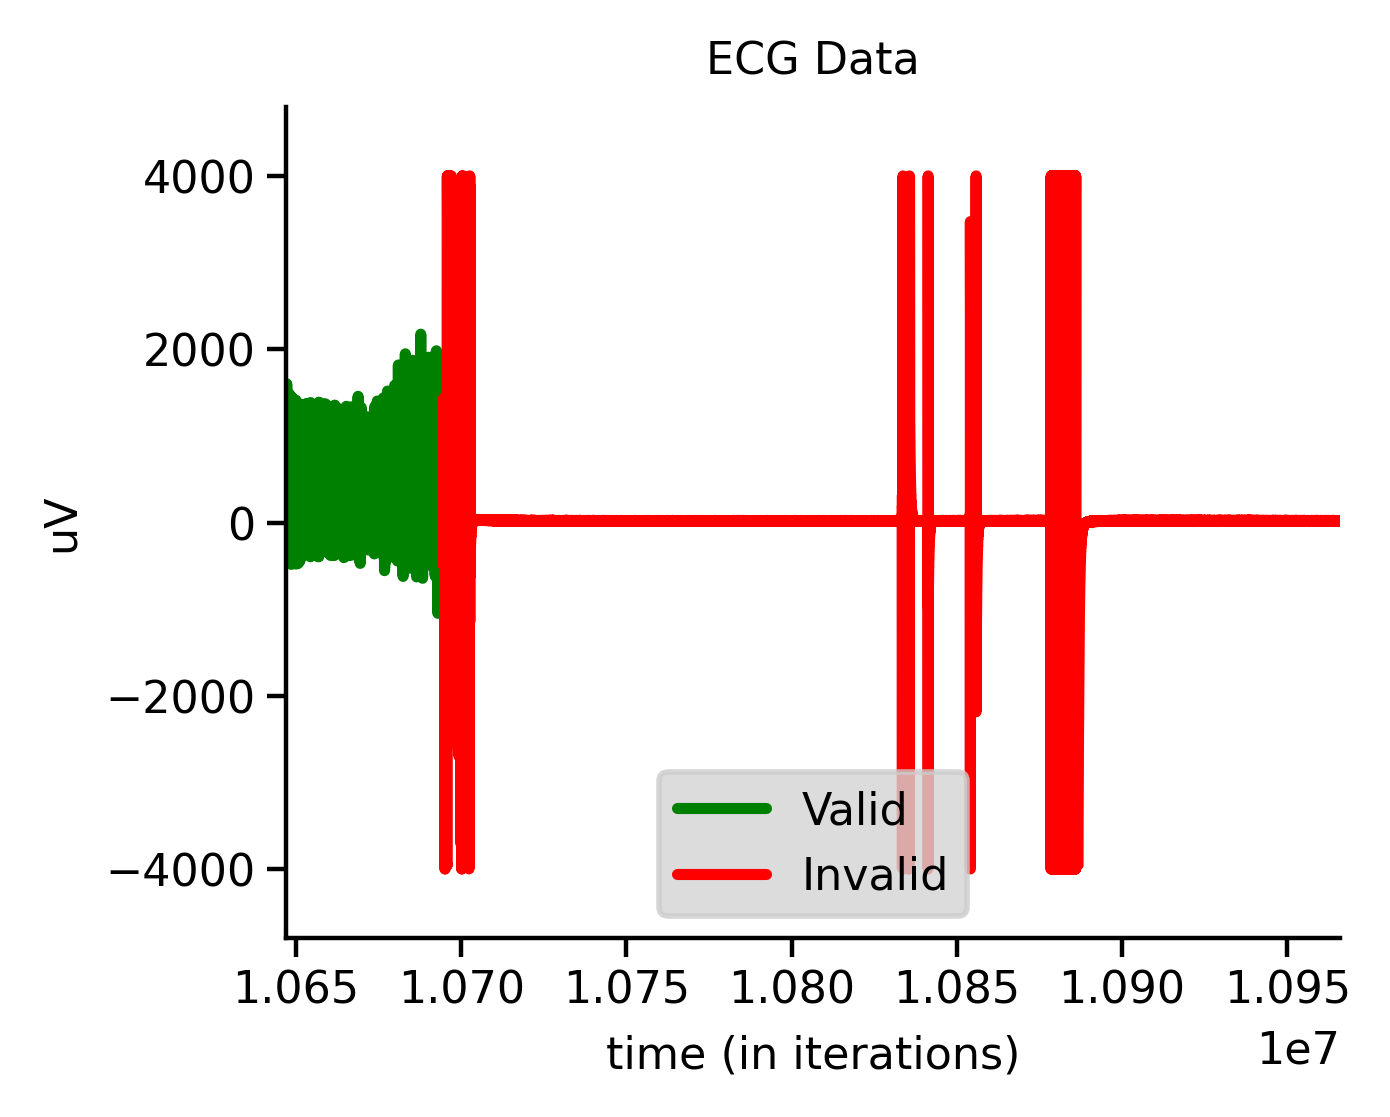

In [21]:
# afterwards look at a specific region that does not match, if necessary:
total_length = len(ECG)
x_lim = [int(0.89*total_length), int(11/12*total_length)]

plot_helper.plot_valid_regions(
    ECG = ECG, 
    valid_regions = this_files_valid_ecg_regions,
    xlim = x_lim
    )

# Plot Detected R-Peak Locations

Note: If computation takes too long, look at valid_ecg_regions. The chosen interval_size might be too big
and must be adjusted.

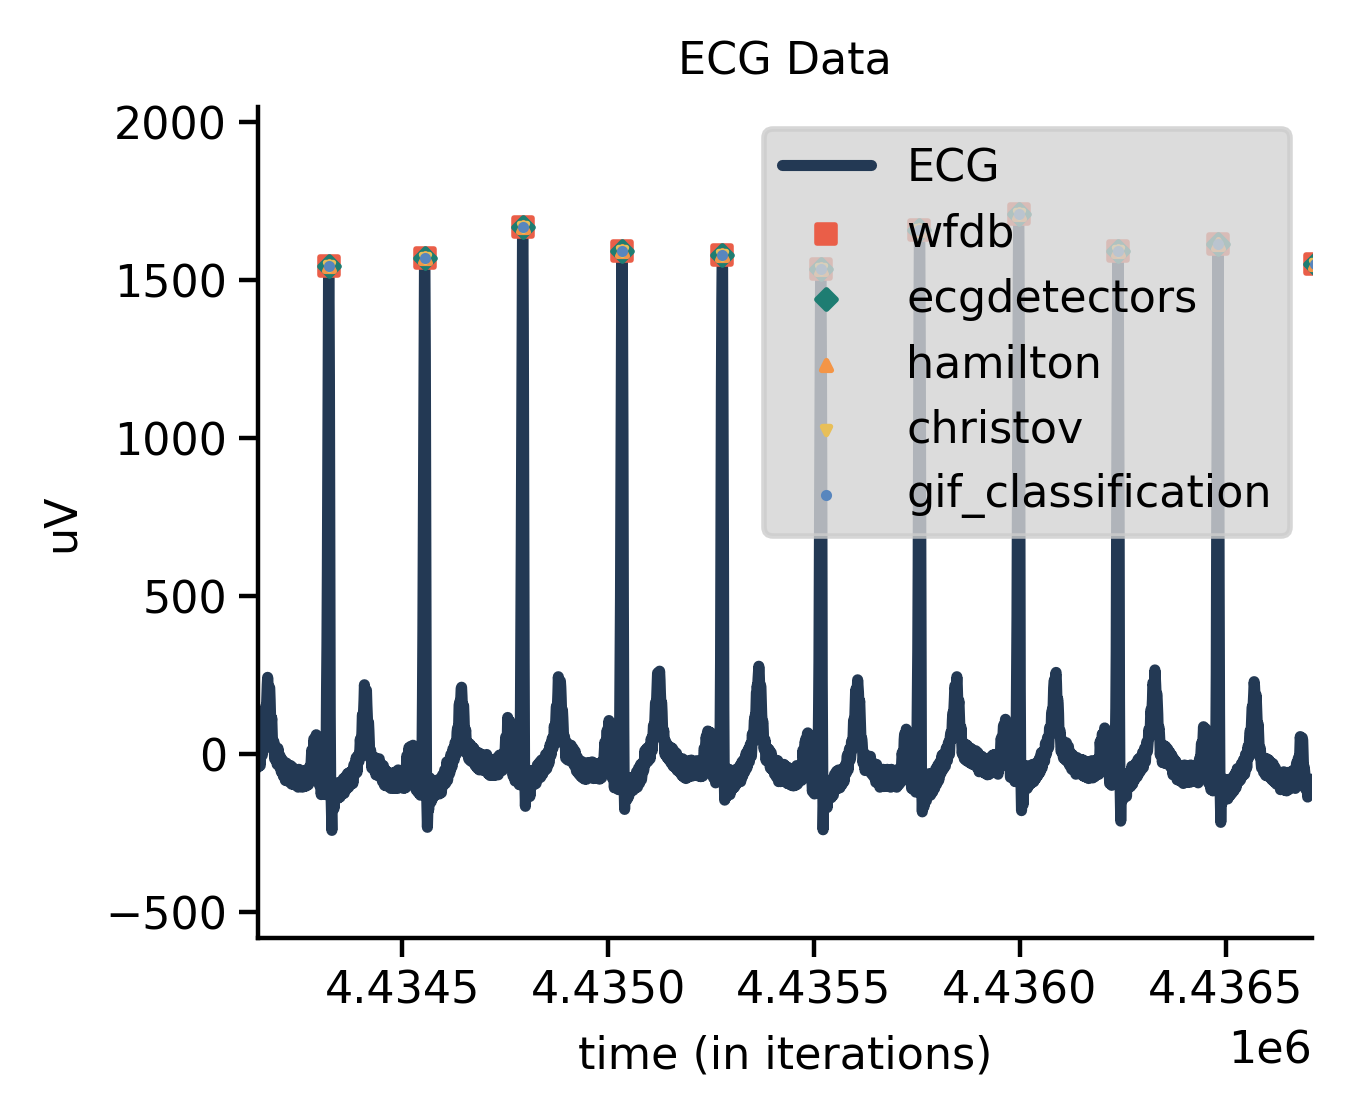

In [22]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL001_SL001_(1).edf"

gif_results_path = "Processed_GIF/GIF_Results.pkl"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 2560

# get r-peak function names
rpeak_function_names = parameters["rpeak_comparison_function_names"]
rpeaks = []

# load the valid regions
results_generator = load_from_pickle(gif_results_path)
for generator_entry in results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_valid_ecg_regions = generator_entry[parameters["valid_ecg_regions_dictionary_key"]]
        for rpeak_function_name in rpeak_function_names:
            rpeaks.append(generator_entry[rpeak_function_name])
        break

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# choose random valid interval
while True:
    random_valid_ecg_region = random.choice(this_files_valid_ecg_regions)
    if random_valid_ecg_region[1] - random_valid_ecg_region[0] >= interval_size:
        break
random_valid_ecg_region_start = random.randint(random_valid_ecg_region[0], random_valid_ecg_region[1] - interval_size)

# x_lim = [708000, 708500]
# x_lim = [1358000, 1359000]
# x_lim = [759000, 759150]
x_lim = [random_valid_ecg_region_start, random_valid_ecg_region_start + interval_size]

plot_helper.plot_rpeak_detection(
    ECG = ECG,
    rpeaks = rpeaks,
    rpeaks_name = rpeak_function_names,
    xlim = x_lim)

# Visualizing R-Peak Comparison

R-peaks are calculated with different libraries for multiple files and afterwards similar r-peaks collected 
(distance smaller 50ms) and compared between two different detectors. 

Following code shows a histogram of the resulting similar / total peaks ratios for one detector pair.

Please also look at the .txt file produced by R-Peak Detection Comparison, as it is way more thorough.

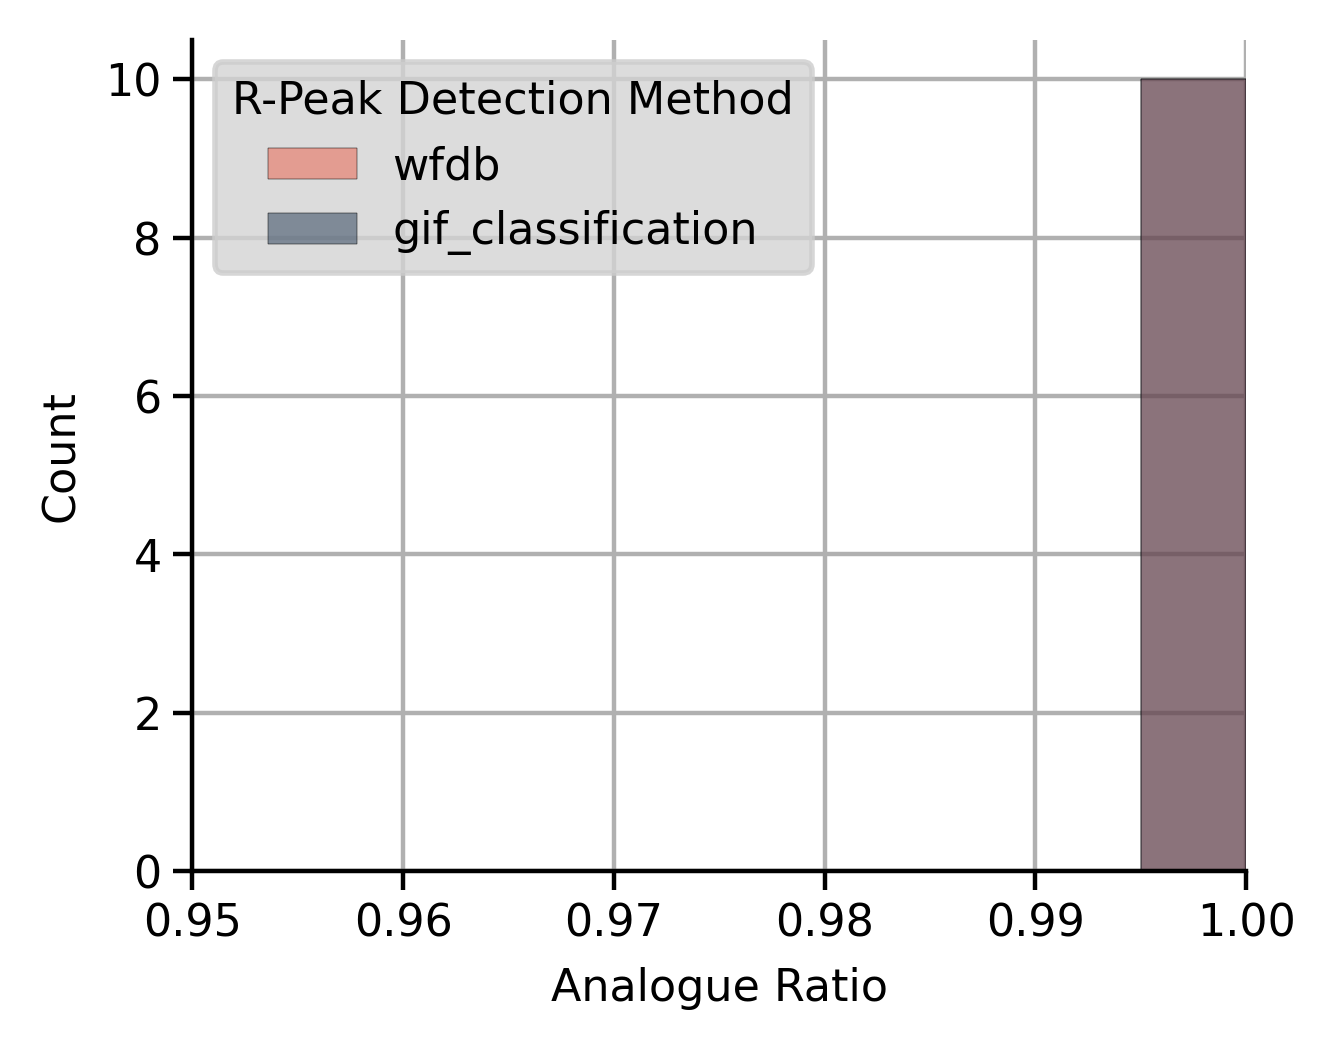

In [23]:
# choose a random detection method pair
first_function_name = "wfdb"
second_function_name = "gif_classification"

gif_results_path = "Processed_GIF/GIF_Results.pkl"

# find the position in the list
position_in_list = 0
for path_index_first in range(len(parameters["rpeak_comparison_function_names"])):
    found_pair = False
    for path_index_second in range(path_index_first+1, len(parameters["rpeak_comparison_function_names"])):
        if parameters["rpeak_comparison_function_names"][path_index_first] == first_function_name and parameters["rpeak_comparison_function_names"][path_index_second] == second_function_name:
            found_pair = True
            break
        if parameters["rpeak_comparison_function_names"][path_index_first] == second_function_name and parameters["rpeak_comparison_function_names"][path_index_second] == first_function_name:
            found_pair = True
            second_function_name = first_function_name
            first_function_name = parameters["rpeak_comparison_function_names"][path_index_second]
            break
        position_in_list += 1
    if found_pair:
        break

# load the data
analogue_ratios_first_function = []
analogue_ratios_second_function = []

results_generator = load_from_pickle(gif_results_path)
for generator_entry in results_generator:
    this_files_rpeak_comparison_values = generator_entry[parameters["rpeak_comparison_dictionary_key"]]
    try:
        analogue_ratios_first_function.append(this_files_rpeak_comparison_values[position_in_list][3]/this_files_rpeak_comparison_values[position_in_list][4])
    except:
        pass
    try:
        analogue_ratios_second_function.append(this_files_rpeak_comparison_values[position_in_list][3]/this_files_rpeak_comparison_values[position_in_list][5])
    except:
        pass

# plot the data
plot_helper.plot_simple_histogram(
    data = [analogue_ratios_first_function, analogue_ratios_second_function],
    label = [first_function_name, second_function_name],
    label_title = "R-Peak Detection Method",
    x_label = "Analogue Ratio",
    y_label = "Count",
    xlim = (0.95, 1),
    binrange = (0, 1),
    binwidth = 0.005,
    kde=False,
)

# Plot Non-Intersecting R-Peaks

After comparing the r-peaks, you might want to look at r-peak detections that do not have a lot 
of peaks in common. 

In the following code you can choose a file and two functions. The intersecting and non-intersecting peaks
will be calculated and one that does not match is randomly chosen and its surroundings are
plotted.

Random r-peak location: 10624597


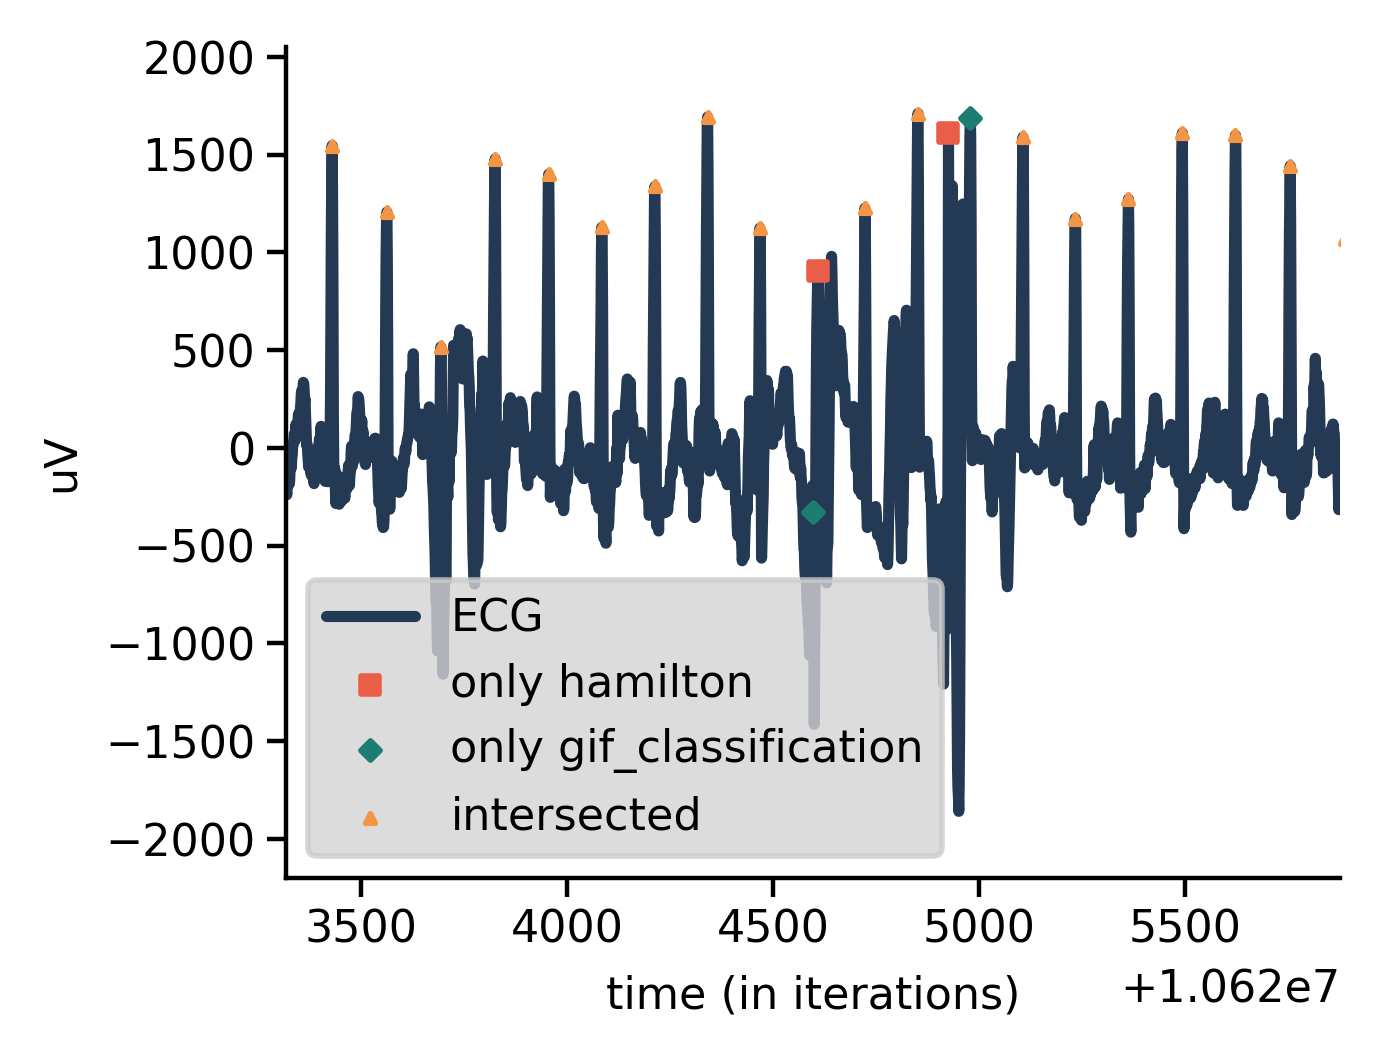

In [29]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL001_SL001_(1).edf"

gif_results_path = "Processed_GIF/GIF_Results.pkl"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 2560

# get r-peak function names ("wfdb", "ecgdetectors", "hamilton", "christov", "gif_classification")
first_rpeak_function_name = "hamilton"
second_rpeak_function_name = "gif_classification"

# load the valid regions
results_generator = load_from_pickle(gif_results_path)
for generator_entry in results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        first_rpeaks = generator_entry[first_rpeak_function_name]
        second_rpeaks = generator_entry[second_rpeak_function_name]
        break

# load the ECG data
ECG, frequency = read_edf.get_data_from_edf_channel(
    file_path = file_data_path,
    possible_channel_labels = parameters["ecg_keys"],
    physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

# combine the r-peaks, retrieve the intersected r-peaks and the r-peaks that are only in the first or second list
rpeaks_intersected, rpeaks_only_primary, rpeaks_only_secondary = main.rpeak_detection.combine_rpeaks(
    rpeaks_primary = first_rpeaks,
    rpeaks_secondary = second_rpeaks,
    frequency = frequency,
    rpeak_distance_threshold_seconds = parameters["rpeak_distance_threshold_seconds"]
)

# choose random r-peak for plotting
random_first_rpeak = random.choice(rpeaks_only_primary)
random_second_rpeak = random.choice(rpeaks_only_secondary)
random_rpeak = random.choice([random_first_rpeak, random_second_rpeak])
print("Random r-peak location: %d" % random_rpeak)

# nice values for plotting
# random_rpeak = 10625000 # for Data/GIF/SOMNOwatch/SL001_SL001_(1).edf, wfdb, gif_classification
# random_rpeak = 10598685
# random_rpeak = 10624597
# random_rpeak = 10622803

x_lim = [int(random_rpeak-interval_size/2), int(random_rpeak+interval_size/2)]

plot_helper.plot_rpeak_detection(
    ECG = ECG,
    rpeaks = [rpeaks_only_primary, rpeaks_only_secondary, rpeaks_intersected],
    rpeaks_name = ["only " + first_rpeak_function_name, "only " + second_rpeak_function_name, "intersected"],
    xlim = x_lim
    )

# Plot MAD Values

Random location: 3370029
[]


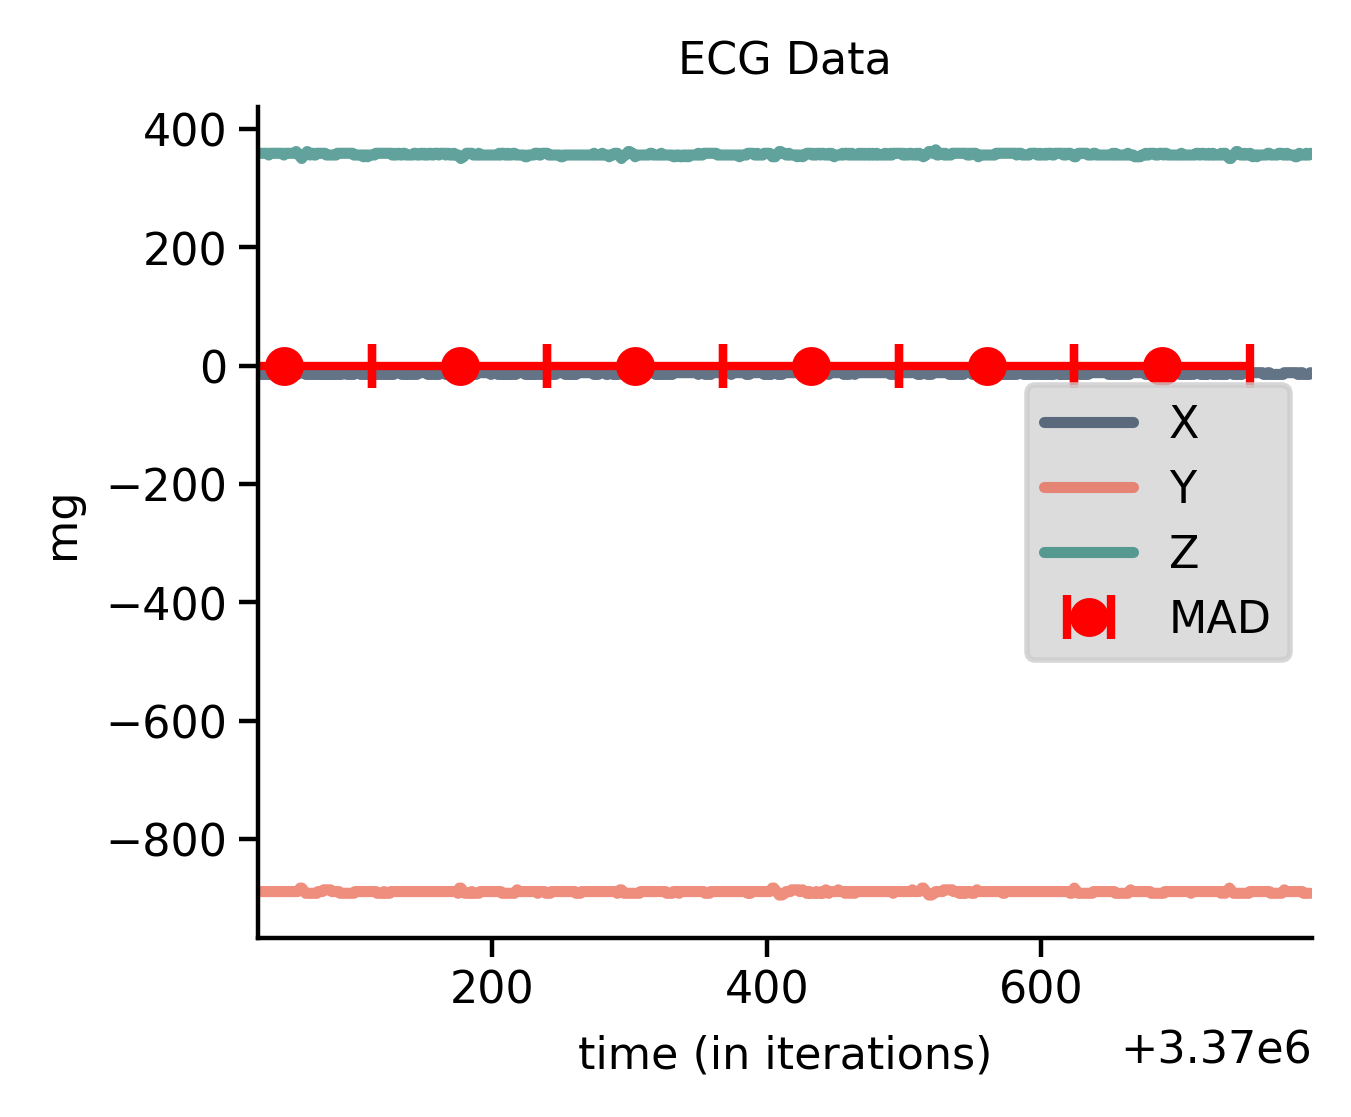

In [25]:
# choose a random file
data_directory = "Data/GIF/SOMNOwatch/"
file_data_name = "SL001_SL001_(1).edf"

gif_results_path = "Processed_GIF/GIF_Results.pkl"

file_data_path = data_directory + file_data_name

# choose size of interval
interval_size = 768 # 6 seconds for 128 Hz

# load the MAD values
results_generator = load_from_pickle(gif_results_path)
for generator_entry in results_generator:
    if generator_entry[parameters["file_name_dictionary_key"]] == file_data_name:
        this_files_MAD_values = generator_entry[parameters["MAD_dictionary_key"]]
        break

# create lists to save the acceleration data and frequencies for each axis
acceleration_data = []
acceleration_data_frequencies = []

# get the acceleration data and frequency for each axis
for possible_axis_keys in parameters["wrist_acceleration_keys"]:
    this_axis_signal, this_axis_frequency = read_edf.get_data_from_edf_channel(
        file_path = file_data_path,
        possible_channel_labels = possible_axis_keys,
        physical_dimension_correction_dictionary = parameters["physical_dimension_correction_dictionary"]
    )

    # append data to corresponding lists
    acceleration_data.append(this_axis_signal)
    acceleration_data_frequencies.append(this_axis_frequency)

# load data and choose random valid interval
total_length = len(acceleration_data[0])
frequency = acceleration_data_frequencies[0]

# choose random region to plot
random_valid_region_start = random.randint(0, total_length - interval_size)
#random_valid_region_start = 1457258
print("Random location: %d" % random_valid_region_start)
x_lim = [random_valid_region_start, random_valid_region_start + interval_size]

print([i for i in range(len(this_files_MAD_values)) if this_files_MAD_values[i] > 0])

plot_helper.plot_MAD_values(
    acceleration_data = acceleration_data,
    frequency = frequency,
    MAD_values = this_files_MAD_values,
    mad_time_period_seconds = parameters["mad_time_period_seconds"], 
    xlim = x_lim
    )